# Install Library dan Package

In [1]:
!pip install keras-tuner --upgrade

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
import math
from google.colab import drive
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from tensorflow.keras.models import load_model
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from pickle import dump,load
import warnings
warnings.simplefilter("ignore", UserWarning)

<ipython-input-2-d331219aa4b0>:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Memanggil Dataset

In [3]:
#Menyiapkan data dan memanggil dataset
drive.mount('/content/drive')
data_set = pd.read_csv('/content/drive/MyDrive/TUGAS AKHIR KURS/kurs_rupiah1.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Mencetak Data

In [4]:
data_set.head()

,Tanggal,Kurs
0,2018-04-05,13767
1,2018-04-06,13771
2,2018-04-09,13771
3,2018-04-10,13759
4,2018-04-11,13747


# Visualisasi Data

<Axes: >

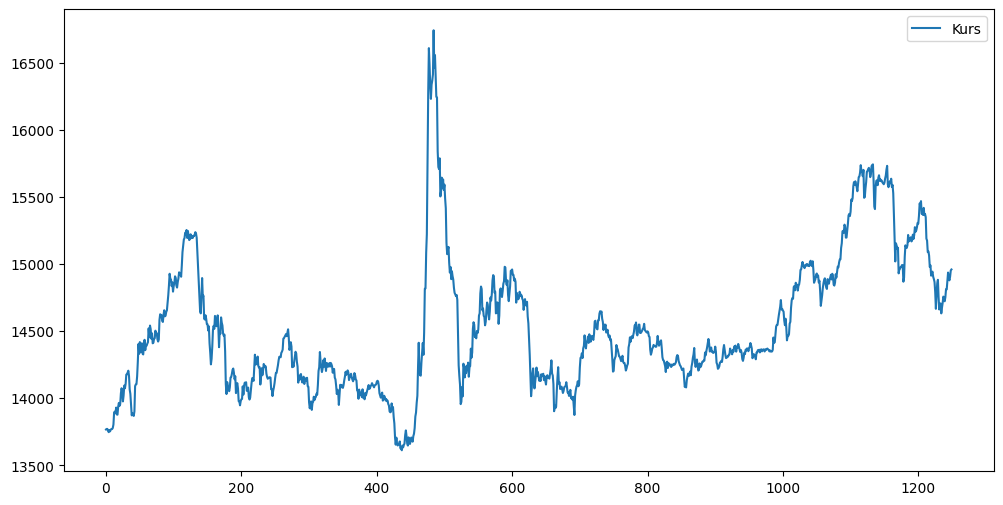

In [5]:
data_set.plot(figsize=(12,6))

# Mengubah Dataframe Menjadi Time Series

In [6]:
df = data_set['Kurs']
df

0       13767
1       13771
2       13771
3       13759
4       13747
        ...  
1245    14897
1246    14878
1247    14905
1248    14952
1249    14959
Name: Kurs, Length: 1250, dtype: int64

# Normalisasi

In [7]:
#Preprocessing data set
df = np.array(df).reshape(-1,1)

In [8]:
#Proses Scalling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
print(df)

[[0.04953659]
 [0.05081496]
 [0.05081496]
 ...
 [0.41323106]
 [0.42825184]
 [0.43048897]]


# Membagi Data Training dan Data Testing

In [9]:
#Training and test sets
train = df[:1000]
test = df[1000:]
print(train.shape)
print(test.shape)

(1000, 1)
(250, 1)


# Membuat Fungsi Sliding/Look Back

In [10]:
def get_data(data, look_back):
    data_x, data_y = [],[]
    for i in range(len(data)-look_back-1):
        data_x.append(data[i:(i+look_back),0])
        data_y.append(data[i+look_back,0])
    return np.array(data_x) , np.array(data_y)

In [11]:
look_back = 1

In [12]:
x_train , y_train = get_data(train, look_back)
print(x_train.shape)
print(y_train.shape)

(998, 1)
(998,)


In [13]:
x_test , y_test = get_data(test,look_back)
print(x_test.shape)
print(y_test.shape)

(248, 1)
(248,)


# Reshape Data

In [14]:
#Processing train and test sets for LSTM model
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)
print(x_train.shape)
print(x_test.shape)

(998, 1, 1)
(248, 1, 1)


In [15]:
# Reshape y_train and y_test
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)
print(y_train.shape)
print(y_test.shape)

(998, 1)
(248, 1)


# Membangun Fungsi Pemodelan

In [16]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(y_train.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

# Tuning Hyperparameter

In [17]:
tuner= RandomSearch(
        build_model,
        objective='mse',
        max_trials=4,
        executions_per_trial=1
        )

In [18]:
tuner.search(
        x=x_train,
        y=y_train,
        epochs=20,
        batch_size=128,
        validation_data=(x_test,y_test),)
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="mse", direction="min")

Trial 2 summary
Hyperparameters:
input_unit: 320
n_layers: 2
lstm_0_units: 416
layer_2_neurons: 128
Dropout_rate: 0.0
dense_activation: relu
lstm_1_units: 224
lstm_2_units: 288
lstm_3_units: 192
Score: 0.00044410990085452795

Trial 3 summary
Hyperparameters:
input_unit: 448
n_layers: 3
lstm_0_units: 512
layer_2_neurons: 352
Dropout_rate: 0.30000000000000004
dense_activation: relu
lstm_1_units: 256
lstm_2_units: 288
lstm_3_units: 64
Score: 0.000521307229064405

Trial 1 summary
Hyperparameters:
input_unit: 64
n_layers: 2
lstm_0_units: 320
layer_2_neurons: 448
Dropout_rate: 0.4
dense_activation: relu
lstm_1_units: 384
lstm_2_units: 448
lstm_3_units: 352
Score: 0.0005553760565817356

Trial 0 summary
Hyperparameters:
input_unit: 480
n_layers: 4
lstm_0_units: 384
layer_2_neurons: 320
Dropout_rate: 0.4
dense_activation: relu
lstm_1_units: 32
lstm_2_units: 32
lstm_3_units: 32
Score: 0.0

In [19]:
# Nilai MSE
mse_1 = 0.0009739082888700068
mse_2 = 0.0005553760565817356
mse_3 = 0.00044410990085452795
mse_4 = 0.000521307229064405
# Menghitung RMSE 10 hari kedepan
RMSE_1 = math.sqrt(mse_1)
RMSE_2 = math.sqrt(mse_2)
RMSE_3 = math.sqrt(mse_3)
RMSE_4 = math.sqrt(mse_4)
print("Root Mean Square Error:\n")
print([RMSE_1,RMSE_2,RMSE_3,RMSE_4])

Root Mean Square Error:

[0.031207503726988592, 0.023566417983684657, 0.021073915176220294, 0.022832153404013494]


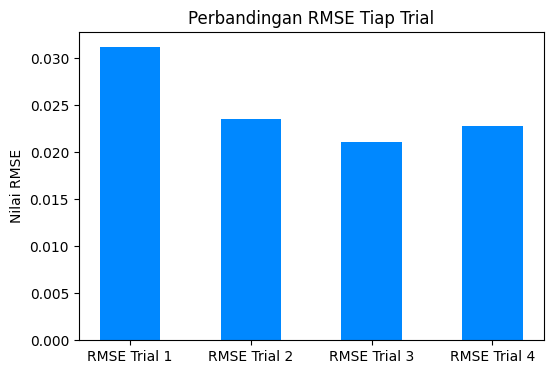

In [23]:
# Label untuk setiap data
label_data = ['RMSE Trial 1', 'RMSE Trial 2','RMSE Trial 3','RMSE Trial 4']

# Plot perbandingan RMSE
plt.figure(figsize=(6, 4))
plt.bar(label_data, [RMSE_1,RMSE_2,RMSE_3,RMSE_4], width=0.5, align='center', color=['#0088ff', '#0088ff','#0088ff','#0088ff'])
plt.xlabel('')
plt.ylabel('Nilai RMSE')
plt.title('Perbandingan RMSE Tiap Trial')
plt.show()

# Menentukan Model Terbaik

In [24]:
best_model = tuner.get_best_models(num_models=1)[0]

In [25]:
best_model.save('Model 1.h5')

In [27]:
# Muat kembali model dari file HDF5
best_model = load_model('Model 1.h5')
# Tampilkan ringkasan model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 320)            412160    
                                                                 
 lstm_1 (LSTM)               (None, 1, 416)            1226368   
                                                                 
 lstm_2 (LSTM)               (None, 1, 224)            574336    
                                                                 
 lstm_3 (LSTM)               (None, 128)               180736    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,393,729
Trainable params: 2,393,729
Non-

In [ ]:
#Defining the LSTM model
n_features=x_train.shape[1]
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(1,1)))
model.add(Dense(n_features))
model.summary()

# Proses Forecasting

In [28]:
y_pred=best_model.predict(x_test)

8/8 [==============================] - 3s 18ms/step


# Hasil Forecasting

In [29]:
y_tests = scaler.inverse_transform(y_test)
print(y_tests)

[[14645.]
 [14578.]
 [14544.]
 [14592.]
 [14526.]
 [14431.]
 [14462.]
 [14464.]
 [14477.]
 [14555.]
 [14569.]
 [14672.]
 [14729.]
 [14746.]
 [14741.]
 [14828.]
 [14836.]
 [14804.]
 [14860.]
 [14835.]
 [14846.]
 [14802.]
 [14837.]
 [14848.]
 [14882.]
 [14956.]
 [14960.]
 [14990.]
 [15015.]
 [14986.]
 [14981.]
 [14969.]
 [14993.]
 [14985.]
 [14999.]
 [14999.]
 [14986.]
 [14992.]
 [14984.]
 [15017.]
 [15024.]
 [14992.]
 [14984.]
 [15020.]
 [14958.]
 [14860.]
 [14874.]
 [14888.]
 [14917.]
 [14929.]
 [14904.]
 [14915.]
 [14862.]
 [14875.]
 [14799.]
 [14688.]
 [14727.]
 [14767.]
 [14822.]
 [14858.]
 [14882.]
 [14893.]
 [14851.]
 [14827.]
 [14814.]
 [14887.]
 [14875.]
 [14853.]
 [14884.]
 [14900.]
 [14920.]
 [14885.]
 [14927.]
 [14905.]
 [14846.]
 [14839.]
 [14861.]
 [14923.]
 [14899.]
 [14939.]
 [14980.]
 [14975.]
 [15011.]
 [15033.]
 [15035.]
 [15119.]
 [15155.]
 [15243.]
 [15247.]
 [15232.]
 [15293.]
 [15276.]
 [15196.]
 [15197.]
 [15246.]
 [15299.]
 [15362.]
 [15373.]
 [15357.]
 [15390.]


In [30]:
#Bandingin dg data testing
y_pred_value = scaler.inverse_transform(y_pred)
print(y_pred_value)

[[14648.508 ]
 [14640.487 ]
 [14573.414 ]
 [14539.4375]
 [14587.416 ]
 [14521.469 ]
 [14426.845 ]
 [14457.681 ]
 [14459.673 ]
 [14472.615 ]
 [14550.426 ]
 [14564.415 ]
 [14667.562 ]
 [14724.793 ]
 [14741.881 ]
 [14736.8545]
 [14824.42  ]
 [14832.481 ]
 [14800.243 ]
 [14856.678 ]
 [14831.475 ]
 [14842.562 ]
 [14798.229 ]
 [14833.49  ]
 [14844.577 ]
 [14878.868 ]
 [14953.592 ]
 [14957.634 ]
 [14987.961 ]
 [15013.246 ]
 [14983.916 ]
 [14978.86  ]
 [14966.73  ]
 [14990.994 ]
 [14982.905 ]
 [14997.062 ]
 [14997.062 ]
 [14983.916 ]
 [14989.983 ]
 [14981.894 ]
 [15015.27  ]
 [15022.351 ]
 [14989.983 ]
 [14981.894 ]
 [15018.304 ]
 [14955.613 ]
 [14856.678 ]
 [14870.798 ]
 [14884.923 ]
 [14914.196 ]
 [14926.314 ]
 [14901.071 ]
 [14912.176 ]
 [14858.694 ]
 [14871.807 ]
 [14795.208 ]
 [14683.616 ]
 [14722.783 ]
 [14763.001 ]
 [14818.374 ]
 [14854.66  ]
 [14878.868 ]
 [14889.969 ]
 [14847.603 ]
 [14823.411 ]
 [14810.314 ]
 [14883.914 ]
 [14871.807 ]
 [14849.619 ]
 [14880.887 ]
 [14897.034 ]
 [1491

In [31]:
print(y_pred_value[:10])

[[14648.508 ]
 [14640.487 ]
 [14573.414 ]
 [14539.4375]
 [14587.416 ]
 [14521.469 ]
 [14426.845 ]
 [14457.681 ]
 [14459.673 ]
 [14472.615 ]]


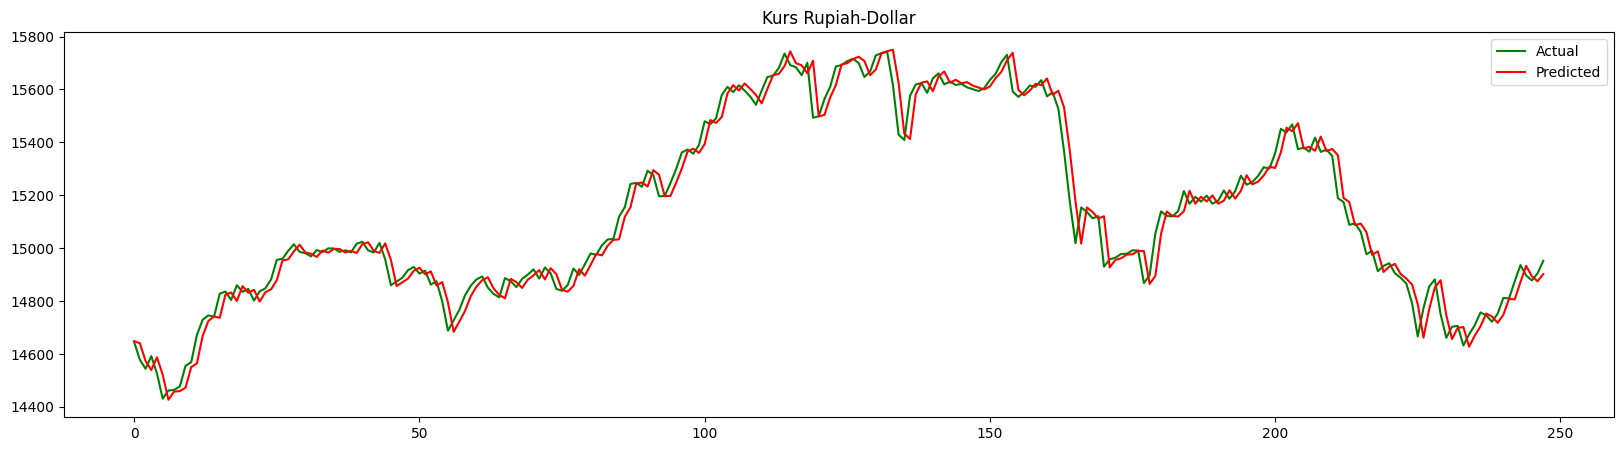

In [32]:
plt.figure(figsize=(20,5))
plt.title('Kurs Rupiah-Dollar')
plt.plot(y_tests , label = 'Actual', color = 'g')
plt.plot(y_pred_value , label = 'Predicted', color = 'r')
plt.legend()

In [36]:
# Menghitung RMSE
MSE = np.square(np.subtract(y_test,y_pred)).mean()
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

0.018191669353572866


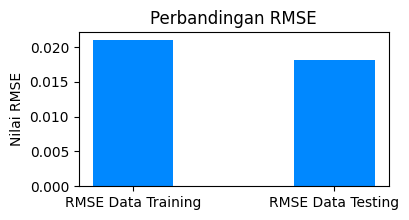

In [37]:
# Nilai MSE
rmse_1 = 0.021073915176220294
rmse_2 = 0.018191669353572866

# Label untuk setiap data
label_data = ['RMSE Data Training', 'RMSE Data Testing']

# Plot perbandingan RMSE
plt.figure(figsize=(4, 2))
plt.bar(label_data, [rmse_1,rmse_2], width=0.4, align='center', color=['#0088ff', '#0088ff'])
plt.xlabel('')
plt.ylabel('Nilai RMSE')
plt.title('Perbandingan RMSE')
plt.show()

In [39]:
# Data training
y_train_pred = best_model.predict(x_train)

# Menghitung MAE pada data training
mae_train = mean_absolute_error(y_train, y_train_pred)
print("MAE pada data training:", mae_train)

# Data testing
y_test_pred = best_model.predict(x_test)

# Menghitung MAE pada data testing
mae_test = mean_absolute_error(y_test, y_test_pred)
print("MAE pada data testing:", mae_test)

32/32 [==============================] - 1s 27ms/step
MAE pada data training: 0.01368545608937769
8/8 [==============================] - 0s 12ms/step
MAE pada data testing: 0.013048276255156359


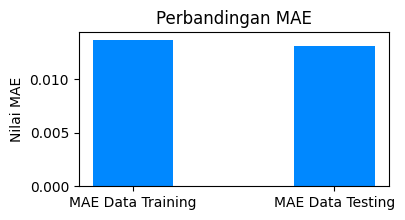

In [40]:
# Nilai MAE
MAE_1 = 0.01368545608937769
MAE_2 = 0.013048276255156359

# Label untuk setiap data
label_data = ['MAE Data Training', 'MAE Data Testing']

# Plot perbandingan RMSE
plt.figure(figsize=(4, 2))
plt.bar(label_data, [MAE_1,MAE_2], width=0.4, align='center', color=['#0088ff', '#0088ff'])
plt.xlabel('')
plt.ylabel('Nilai MAE')
plt.title('Perbandingan MAE')
plt.show()